In [1]:
!pip install xgboost

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import math
import itertools 
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import scipy
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from statistics import mean
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import normalize, StandardScaler,RobustScaler,MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score,roc_curve,auc, roc_auc_score, fbeta_score,plot_roc_curve,plot_precision_recall_curve,confusion_matrix,average_precision_score,precision_recall_curve
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from xgboost import XGBClassifier
from prettytable import PrettyTable
import re
import scipy.stats as ss
from tqdm import tqdm
import pickle
from tqdm import tqdm
import os
import joblib


# 1. Data Preprocessing

<h2>1.1 Loading Dataset <h2>

In [3]:
# Unrar the file
!unrar x "/content/dataset.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/dataset.rar

Extracting  Kaggle_Training_Dataset_v2.csv                                 0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87%  OK 
Extracting  Kaggle_Test_Dataset_v2.csv                                    87% 88% 89% 90%

In [4]:
# Read the csv file
df_train=pd.read_csv("/content/Kaggle_Training_Dataset_v2.csv")
df_test=pd.read_csv("/content/Kaggle_Test_Dataset_v2.csv")

In [5]:
df_train

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687856,1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,No,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No
1687857,1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,0.0,No,0.0,0.86,0.84,1.0,Yes,No,No,No,No,Yes
1687858,1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,12.0,No,0.0,0.86,0.84,6.0,No,No,No,Yes,No,No
1687859,1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,20.0,1.0,No,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No


In [6]:
df_test

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3285085,62.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
1,3285131,9.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,-99.00,-99.00,0.0,No,No,Yes,No,No,No
2,3285358,17.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.92,0.95,0.0,No,No,No,Yes,No,No
3,3285517,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,No,0.0,0.78,0.75,0.0,No,No,Yes,Yes,No,No
4,3285608,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.54,0.71,0.0,No,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242071,3526988,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242072,3526989,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242073,3526990,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242074,3526991,2913.0,12.0,0.0,0.0,0.0,0.0,0.0,30.0,88.0,88.0,4.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No


## 1.2 Dropping the last record which contains NaN

In [7]:
#Dropping last record of train and test dataset
df_train=df_train[:-1]
df_test=df_test[:-1]

# 2. Feature Engineering

## 2.1 Converting  Boolean values to Binary values 

In [8]:
# Encode categorical columns with values Yes and No to 1 and 0 respectively

#Creating dictionary with mapping values
dict_map_bool={'Yes':1.0,'No':0.0}

#Train data
df_train['deck_risk']=df_train['deck_risk'].map(dict_map_bool)
df_train['potential_issue']=df_train['potential_issue'].map(dict_map_bool)
df_train['oe_constraint']=df_train['oe_constraint'].map(dict_map_bool)
df_train['ppap_risk']=df_train['ppap_risk'].map(dict_map_bool)
df_train['stop_auto_buy']=df_train['stop_auto_buy'].map(dict_map_bool)
df_train['rev_stop']=df_train['rev_stop'].map(dict_map_bool)
df_train['went_on_backorder']=df_train['went_on_backorder'].map(dict_map_bool)

#Test data
df_test['deck_risk']=df_test['deck_risk'].map(dict_map_bool)
df_test['potential_issue']=df_test['potential_issue'].map(dict_map_bool)
df_test['oe_constraint']=df_test['oe_constraint'].map(dict_map_bool)
df_test['ppap_risk']=df_test['ppap_risk'].map(dict_map_bool)
df_test['stop_auto_buy']=df_test['stop_auto_buy'].map(dict_map_bool)
df_test['rev_stop']=df_test['rev_stop'].map(dict_map_bool)
df_test['went_on_backorder']=df_test['went_on_backorder'].map(dict_map_bool)

## 2.2 Replacing unknown values

In [9]:
#Replacing -99 in perfomance columns with nan

#Train data
df_train.perf_6_month_avg.replace({-99.0 : np.nan}, inplace = True)
df_train.perf_12_month_avg.replace({-99.0 : np.nan}, inplace = True)

#Test data
df_test.perf_6_month_avg.replace({-99.0 : np.nan}, inplace = True)
df_test.perf_12_month_avg.replace({-99.0 : np.nan}, inplace = True)

## 2.3 Handling missing values

In [10]:
#Using Iterative Imputer method to replace missing values

X_train_iter = df_train.copy()
X_test_iter= df_test.copy()
iter = IterativeImputer(max_iter=10, random_state=0)
iter.fit(X_train_iter)
X_train_iter[:] = iter.transform(X_train_iter)
X_test_iter[:] = iter.transform(X_test_iter)



## 2.4 Correlation of numerical features with target variable

In [11]:
#Numerical columns list
num_col_list=['national_inv','lead_time','in_transit_qty','forecast_3_month','forecast_6_month','forecast_9_month','sales_1_month','sales_3_month','sales_6_month','sales_9_month','min_bank','pieces_past_due','perf_6_month_avg','perf_12_month_avg','local_bo_qty']

In [12]:
# Correlation using Point Biserial correlation
y_train=df_train['went_on_backorder']

print('Correlation between numeric features and target variable')
print('--------------------------------------------------------')
for col in num_col_list:
  a = y_train
  b = X_train_iter[col]
  num_corr = scipy.stats.pointbiserialr(a, b)
  print('{} and {} -----> \t\t{}'.format(col, 'went_on_backorder', num_corr))


Correlation between numeric features and target variable
--------------------------------------------------------
national_inv and went_on_backorder -----> 		PointbiserialrResult(correlation=-0.0013154647696244318, pvalue=0.0874471334845229)
lead_time and went_on_backorder -----> 		PointbiserialrResult(correlation=-0.01850616614283375, pvalue=9.457119442081025e-128)
in_transit_qty and went_on_backorder -----> 		PointbiserialrResult(correlation=-0.0024273867494043542, pvalue=0.0016126636005431524)
forecast_3_month and went_on_backorder -----> 		PointbiserialrResult(correlation=-0.0003396959044041529, pvalue=0.6589779651352116)
forecast_6_month and went_on_backorder -----> 		PointbiserialrResult(correlation=-0.0008404611441741213, pvalue=0.2748740303805967)
forecast_9_month and went_on_backorder -----> 		PointbiserialrResult(correlation=-0.0010298274405346802, pvalue=0.18092018915476213)
sales_1_month and went_on_backorder -----> 		PointbiserialrResult(correlation=-0.0011305696825252827,

* perfomance columns have the highest correlation with the target variable
* Lead_time also show some correlation with the target variable
* Rest columns are not much correlated with the target variable
* local_bo_qty and pieces_past_due are the only features which are positively correlated with the target variable.


## 2.5 Raw Data features Visualization Before Transformations

In [13]:
df_train_num_untrans=df_train.copy()
df_train_num_untrans=df_train_num_untrans.drop(['sku','potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop' ], axis=1)

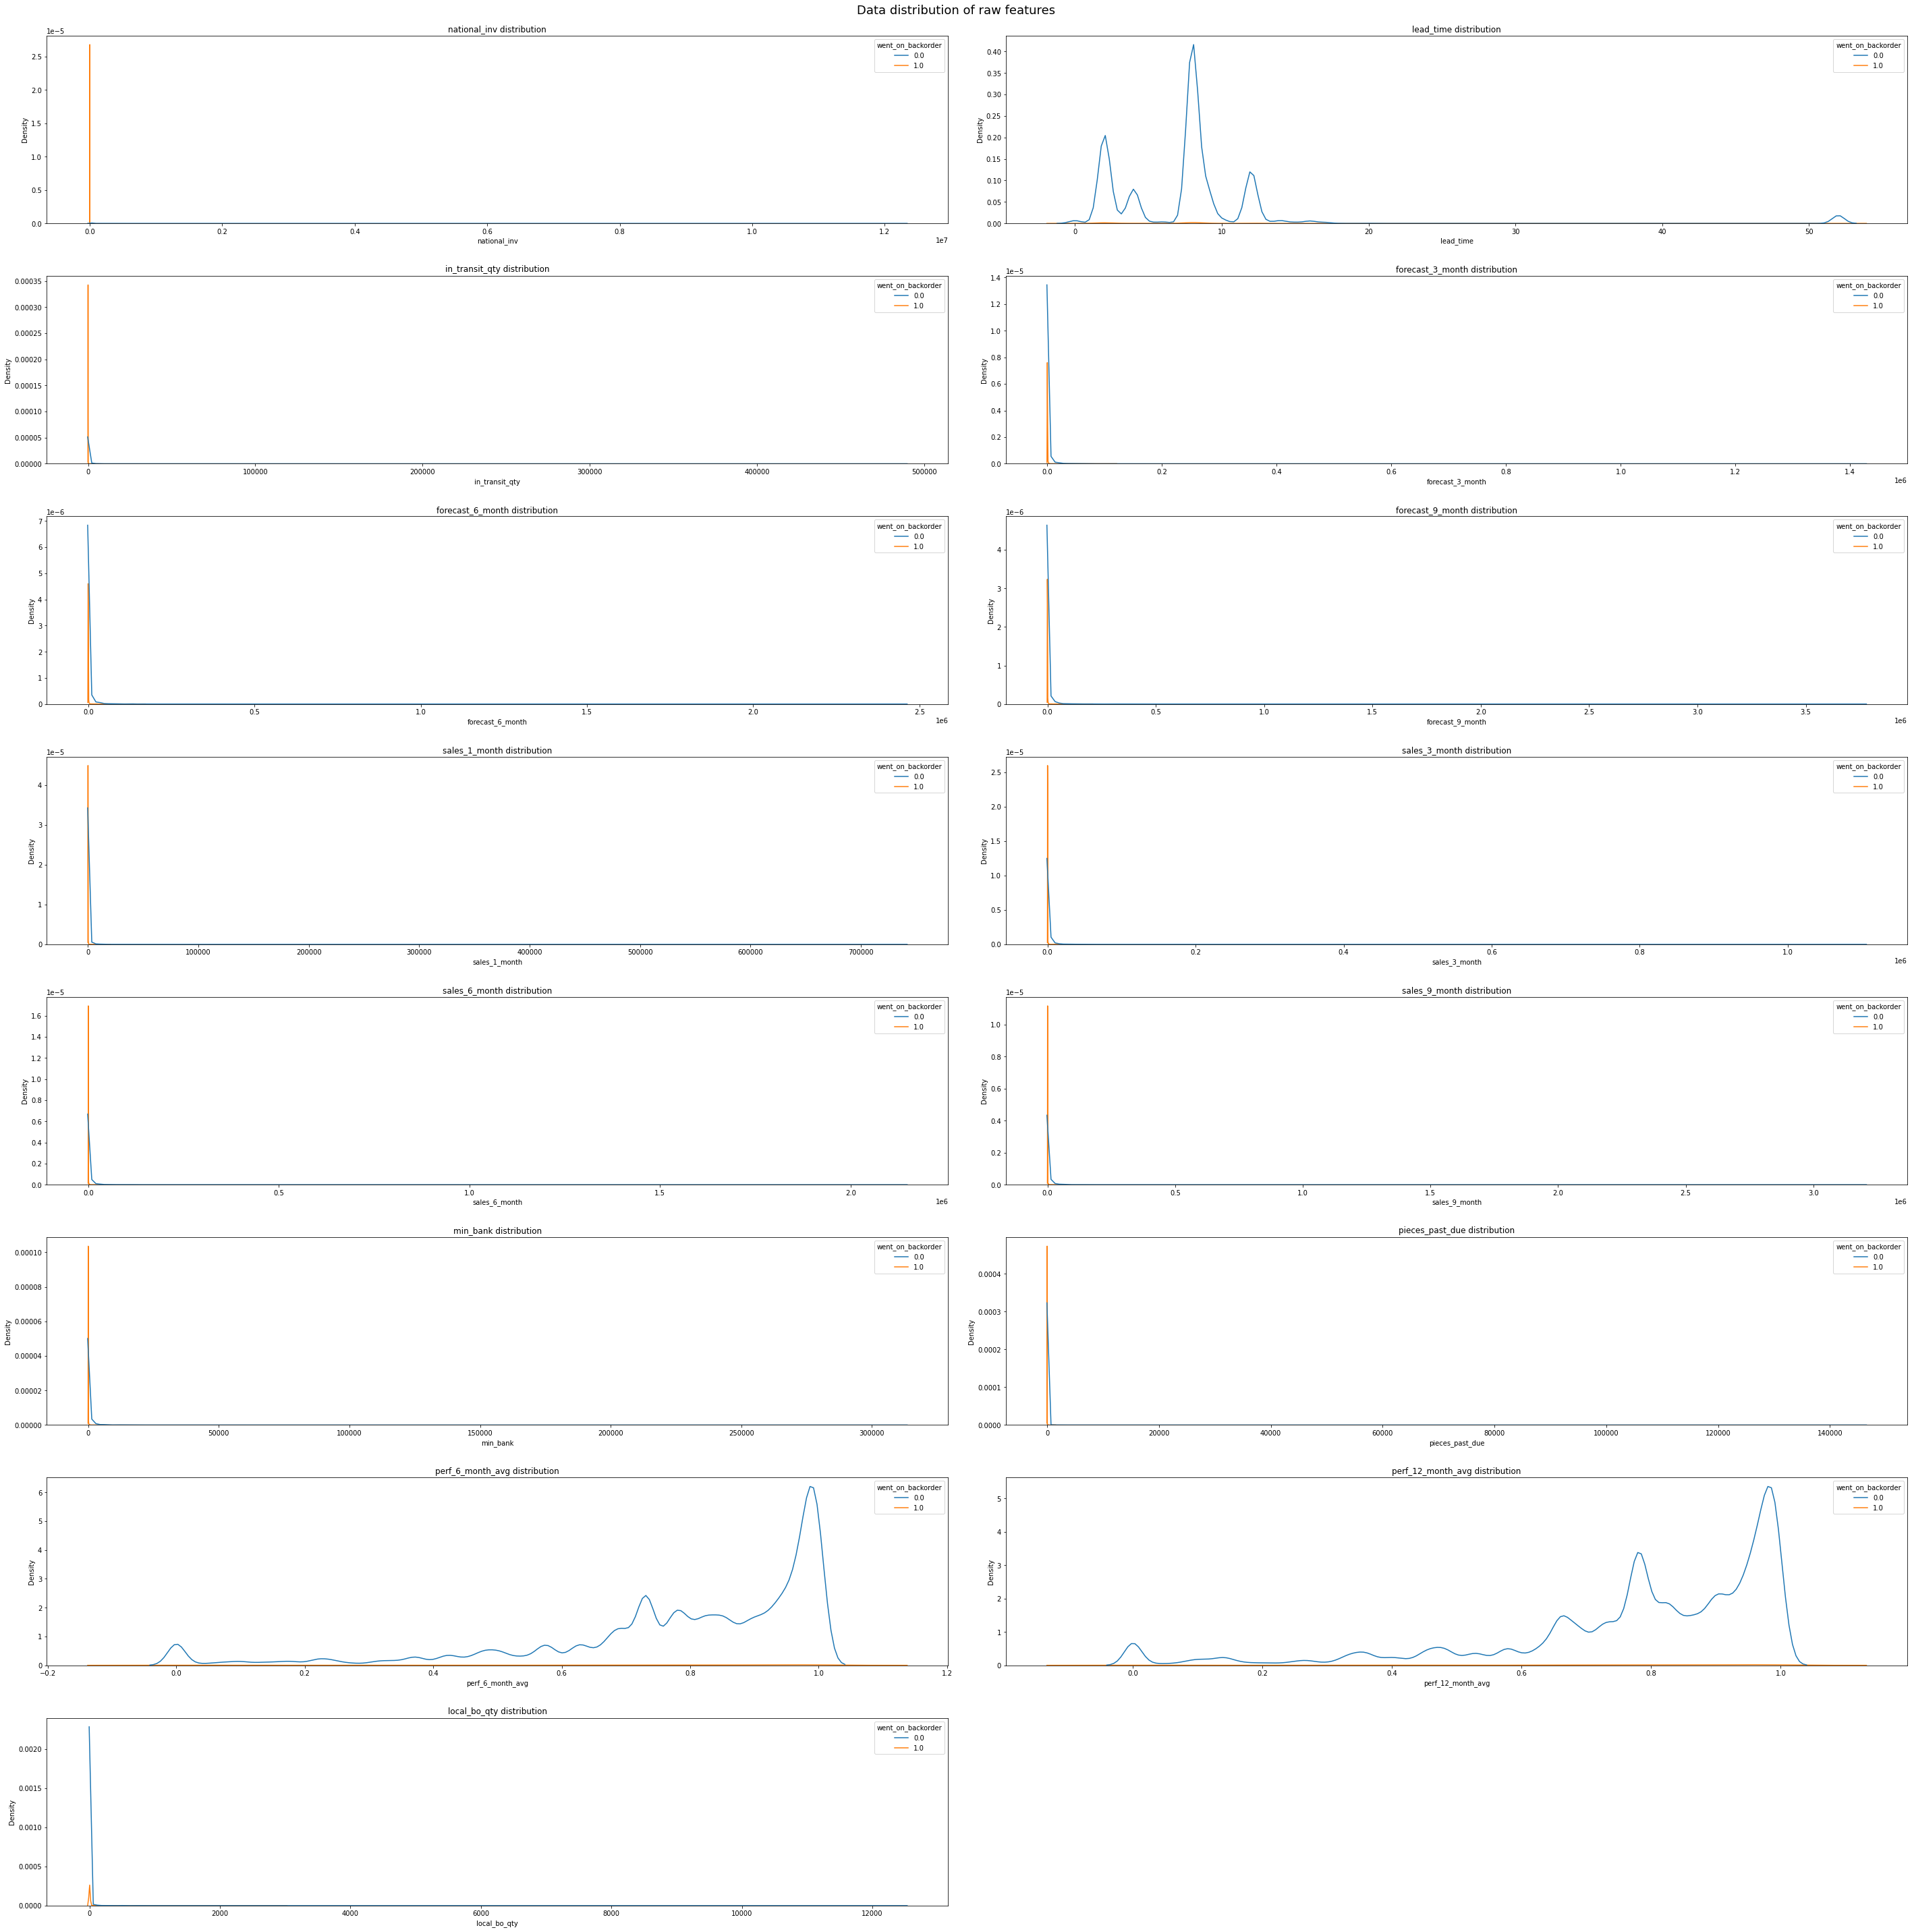

In [14]:
#Distribution of raw features before transformations
fig = plt.figure(figsize=(40,40))
for idx, val in enumerate(df_train_num_untrans.drop(['went_on_backorder'], axis=1)):
  ax1=fig.add_subplot(8, 2, idx+1)
  ax1.title.set_text(val+' distribution')
  sns.kdeplot(data = df_train_num_untrans, x=val, hue='went_on_backorder')
fig.tight_layout(pad=3.0)
fig.suptitle("Data distribution of raw features", fontsize=18, y=1, x=.5)
plt.show()

* It is difficult to seperate out the classes in these features as they are high overlapping

## 2.6 Transformed Features Visualization

In [15]:
X_train_iter_stand=X_train_iter.copy()
X_test_iter_stand=X_test_iter.copy()

In [16]:
#Applying Standard Scaler

sc = StandardScaler().fit(X_train_iter_stand[num_col_list].values)
X_tr_sc_num_feat=sc.transform(X_train_iter_stand[num_col_list].values)
X_te_sc_num_feat=sc.transform(X_test_iter_stand[num_col_list].values)

X_tr_sc_num_feat = pd.DataFrame(X_tr_sc_num_feat, index=X_train_iter_stand.index, columns=num_col_list)
X_te_sc_num_feat = pd.DataFrame(X_te_sc_num_feat, index=X_test_iter_stand.index, columns=num_col_list)

In [17]:
#Assigning numerical columns to original dataframe

for i in num_col_list:
  X_train_iter_stand[i]=X_tr_sc_num_feat[i]
  X_test_iter_stand[i]=X_te_sc_num_feat[i]

In [18]:
##Random Undersample the dataset to balance the data

undersample = RandomUnderSampler()
X_train_iter_under, y_train_iter_under = undersample.fit_resample(X_train_iter_stand, y_train)

In [19]:
#Creating undersampled dataframes for train set

X_train_iter_under=pd.DataFrame(X_train_iter_under, columns=X_train_iter_stand.columns)
y_train_iter_under=pd.DataFrame(y_train_iter_under,columns=['went_on_backorder'])

In [20]:
#Creating dataframes with numerical features for train and test set

X_train_iter_under_num=X_train_iter_under.drop(columns=['sku','potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop'],axis=1)
X_test_iter_num=X_test_iter_stand.drop(columns=['sku','potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop'],axis=1)

## 2.7 Creating New Transformed features

In [21]:
#Function to fit logistic regression model
def model(df_final,y):
  log_reg = LogisticRegression()
  log_reg.fit(df_final, y)
  return log_reg

  
#Function to perform addition of features  
def add(df,num_cols):
  for i in num_cols:
    for j in num_cols:
      if (i!=j):
        df[i+'_'+j+'_add']=df[i]+df[j]
  return df
  
#Function to perform multiplication of features
def mult(df,num_cols):
  for i in num_cols:
    for j in num_cols:
      if (i!=j):
        df[i+'_'+j+'_mult']=df[i]*df[j]
  return df
  

#Function to perform inverse of features
def inv(df,num_cols):
    for i in num_cols:
      df[i+'_'+'inv']=1/(df[i]+0.001)

    return df

#Function to perform square of features
def square(df,num_cols):
  for i in num_cols:
    df[i+'_'+'square']=df[i] * df[i]
  return df

#Function to perform square root of features
def sqrt(df,num_cols):
  for i in num_cols:
    df[i+'_'+'square_root']=np.sqrt(abs(df[i]))
  return df

#Function to perform log of features
def log(df,num_cols):
  for i in num_cols:
    df[i+'_'+'log']= (np.log(abs(df[i])+1))
  return df

In [22]:
#Applying tranformed functions on train data
X_train_iter_trans=add(X_train_iter_under_num,num_col_list)
X_train_iter_trans=mult(X_train_iter_trans,num_col_list)
X_train_iter_trans=inv(X_train_iter_trans,num_col_list)
X_train_iter_trans=square(X_train_iter_trans,num_col_list)
X_train_iter_trans=sqrt(X_train_iter_trans,num_col_list)
X_train_iter_trans=log(X_train_iter_trans,num_col_list)

#Applying tranformed functions on test data
X_test_iter_trans=add(X_test_iter_num,num_col_list)
X_test_iter_trans=mult(X_test_iter_trans,num_col_list)
X_test_iter_trans=inv(X_test_iter_trans,num_col_list)
X_test_iter_trans=square(X_test_iter_trans,num_col_list)
X_test_iter_trans=sqrt(X_test_iter_trans,num_col_list)
X_test_iter_trans=log(X_test_iter_trans,num_col_list)



In [23]:
y_train_iter_trans=X_train_iter_trans['went_on_backorder'].values
y_test_iter_trans=X_test_iter_trans['went_on_backorder'].values

X_train_iter_trans=X_train_iter_trans.drop(['went_on_backorder'],axis=1)
X_test_iter_trans=X_test_iter_trans.drop(['went_on_backorder'],axis=1)


#applying logistic regression
model=model(X_train_iter_trans,y_train_iter_trans)
importances = model.coef_
abs_imp=np.abs(importances[0])

#get the sorting indices
sorted_idx = (-abs_imp).argsort()

In [24]:
#print top 20 most important columns
for i in sorted_idx[:20]:
  print(X_train_iter_trans.columns[i])

local_bo_qty_inv
lead_time_inv
in_transit_qty_inv
local_bo_qty_square
pieces_past_due_inv
perf_6_month_avg_square
perf_12_month_avg_square
perf_6_month_avg_perf_12_month_avg_mult
perf_12_month_avg_perf_6_month_avg_mult
perf_6_month_avg_perf_12_month_avg_add
perf_12_month_avg_perf_6_month_avg_add
perf_6_month_avg_inv
in_transit_qty_square
perf_6_month_avg_lead_time_add
lead_time_perf_6_month_avg_add
lead_time_perf_12_month_avg_add
perf_12_month_avg_lead_time_add
lead_time_square
sales_6_month_inv
in_transit_qty_perf_6_month_avg_add


In [25]:
X_train_iter_trans_plt=X_train_iter_trans.copy()
X_train_iter_trans_plt['went_on_backorder']=y_train_iter_trans

### 2.8 Plot of original and transformed features

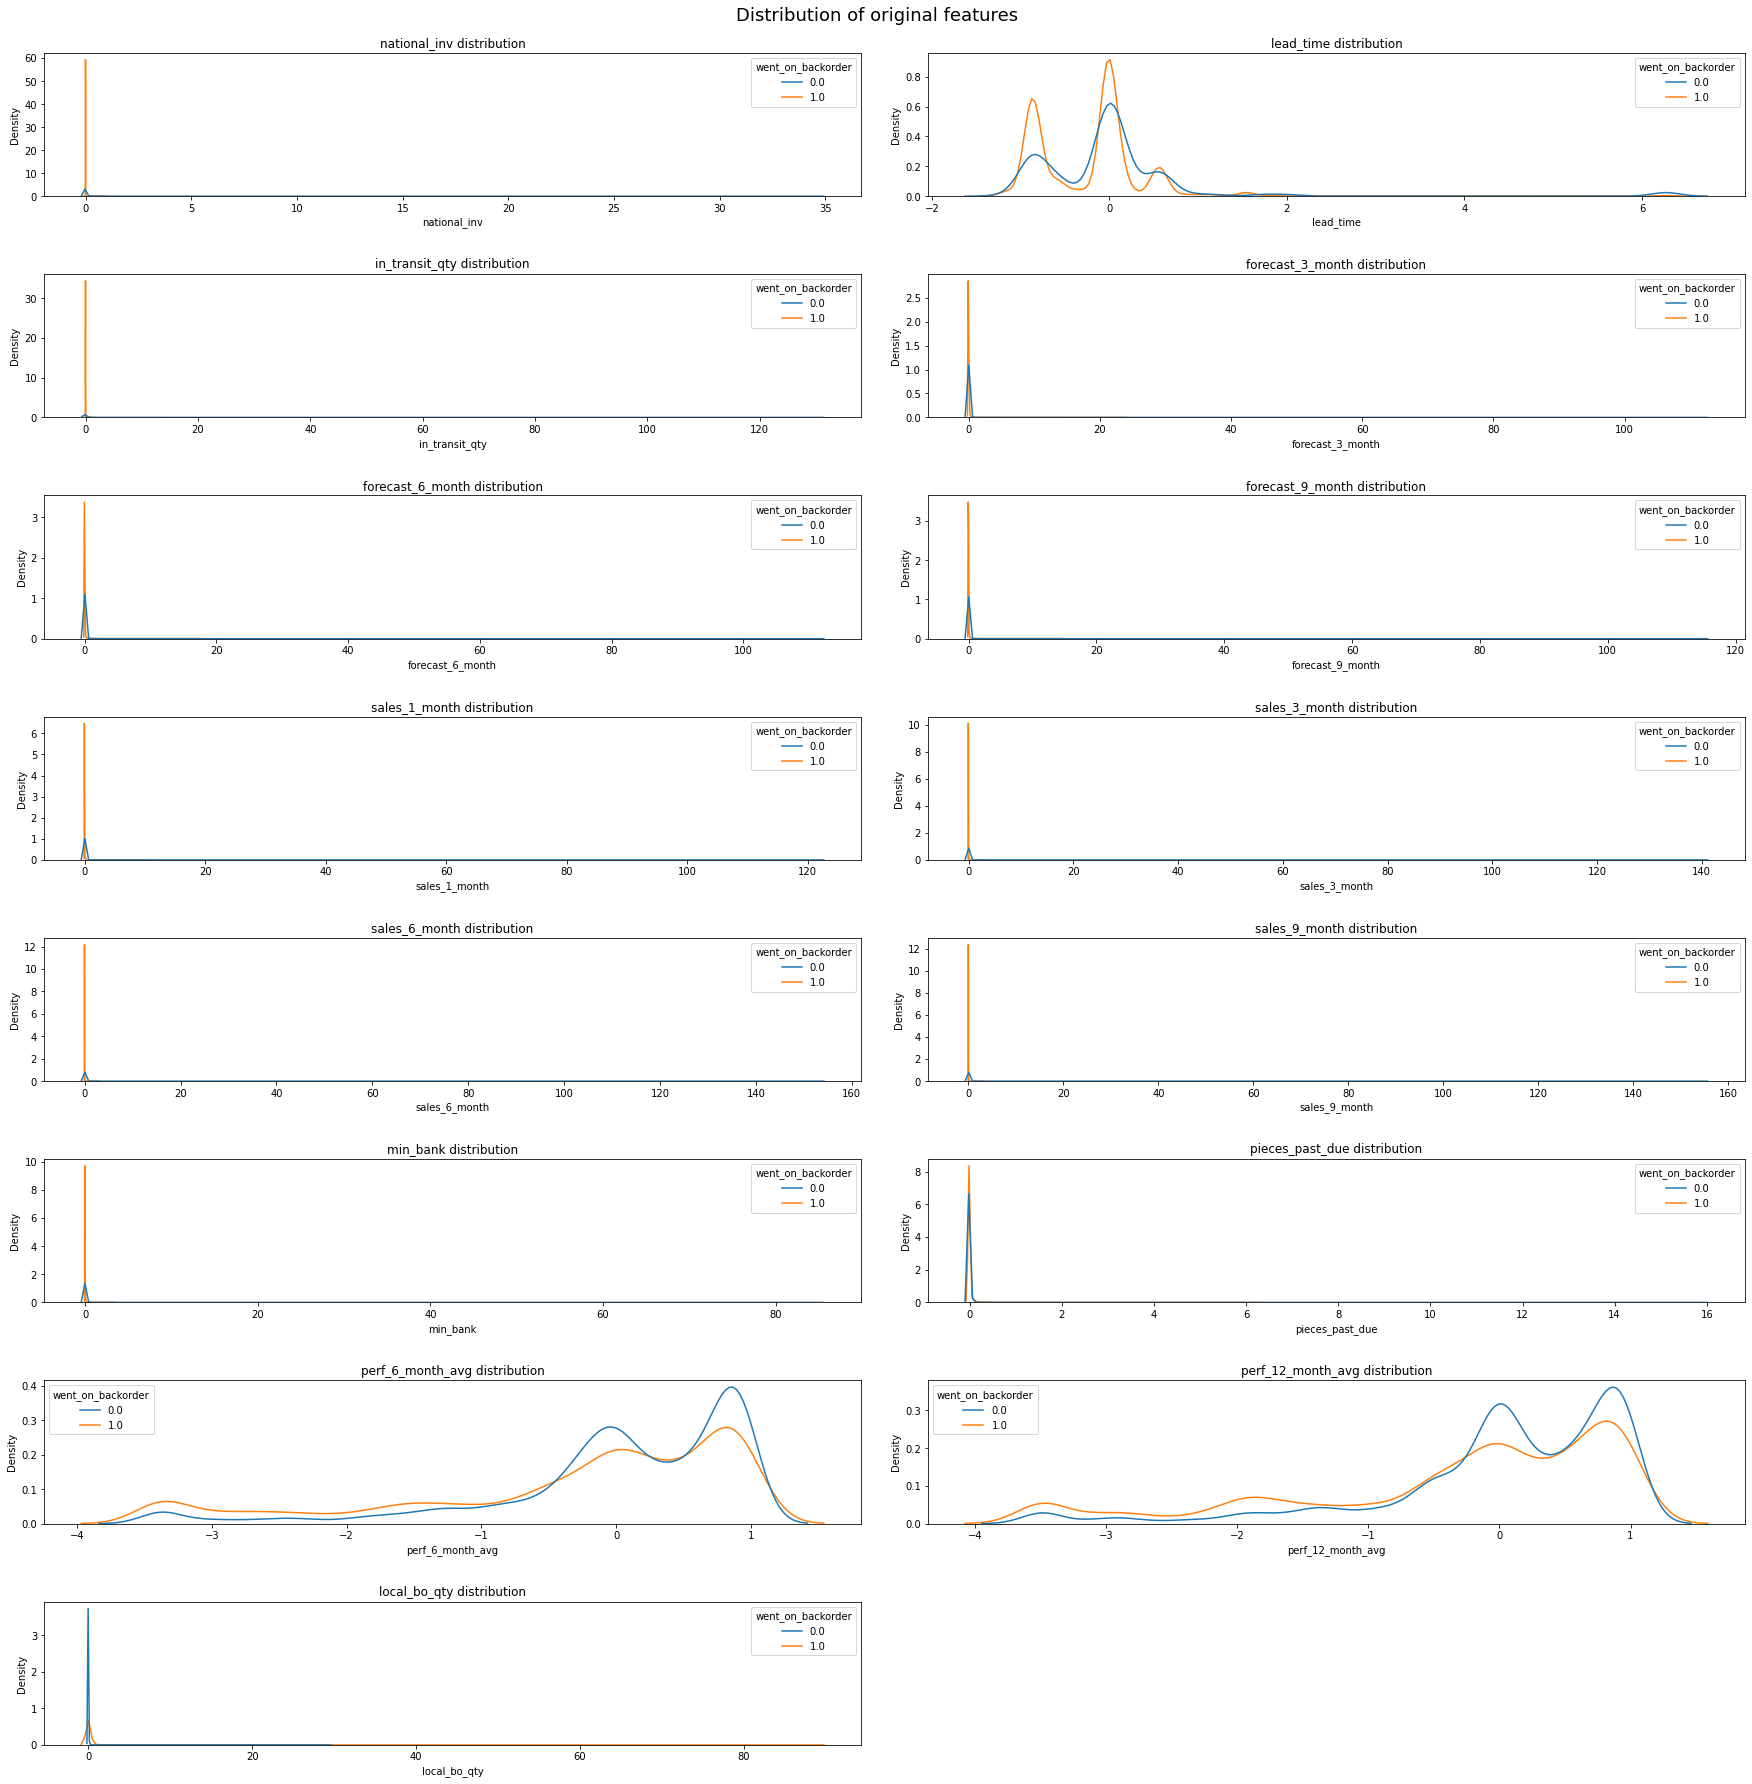

In [26]:
#Distribution of original features

fig = plt.figure(figsize=(25,25))
for i,j in enumerate(num_col_list):

  ax1=fig.add_subplot(8, 2, i+1)
  p=X_train_iter_trans[j]
  ax1.title.set_text(j+' distribution')
  sns.kdeplot(data = X_train_iter_trans_plt, x=num_col_list[i], hue='went_on_backorder')
fig.tight_layout(pad=3.0)
fig.suptitle("Distribution of original features", fontsize=18, y=1, x=.5)
plt.show()

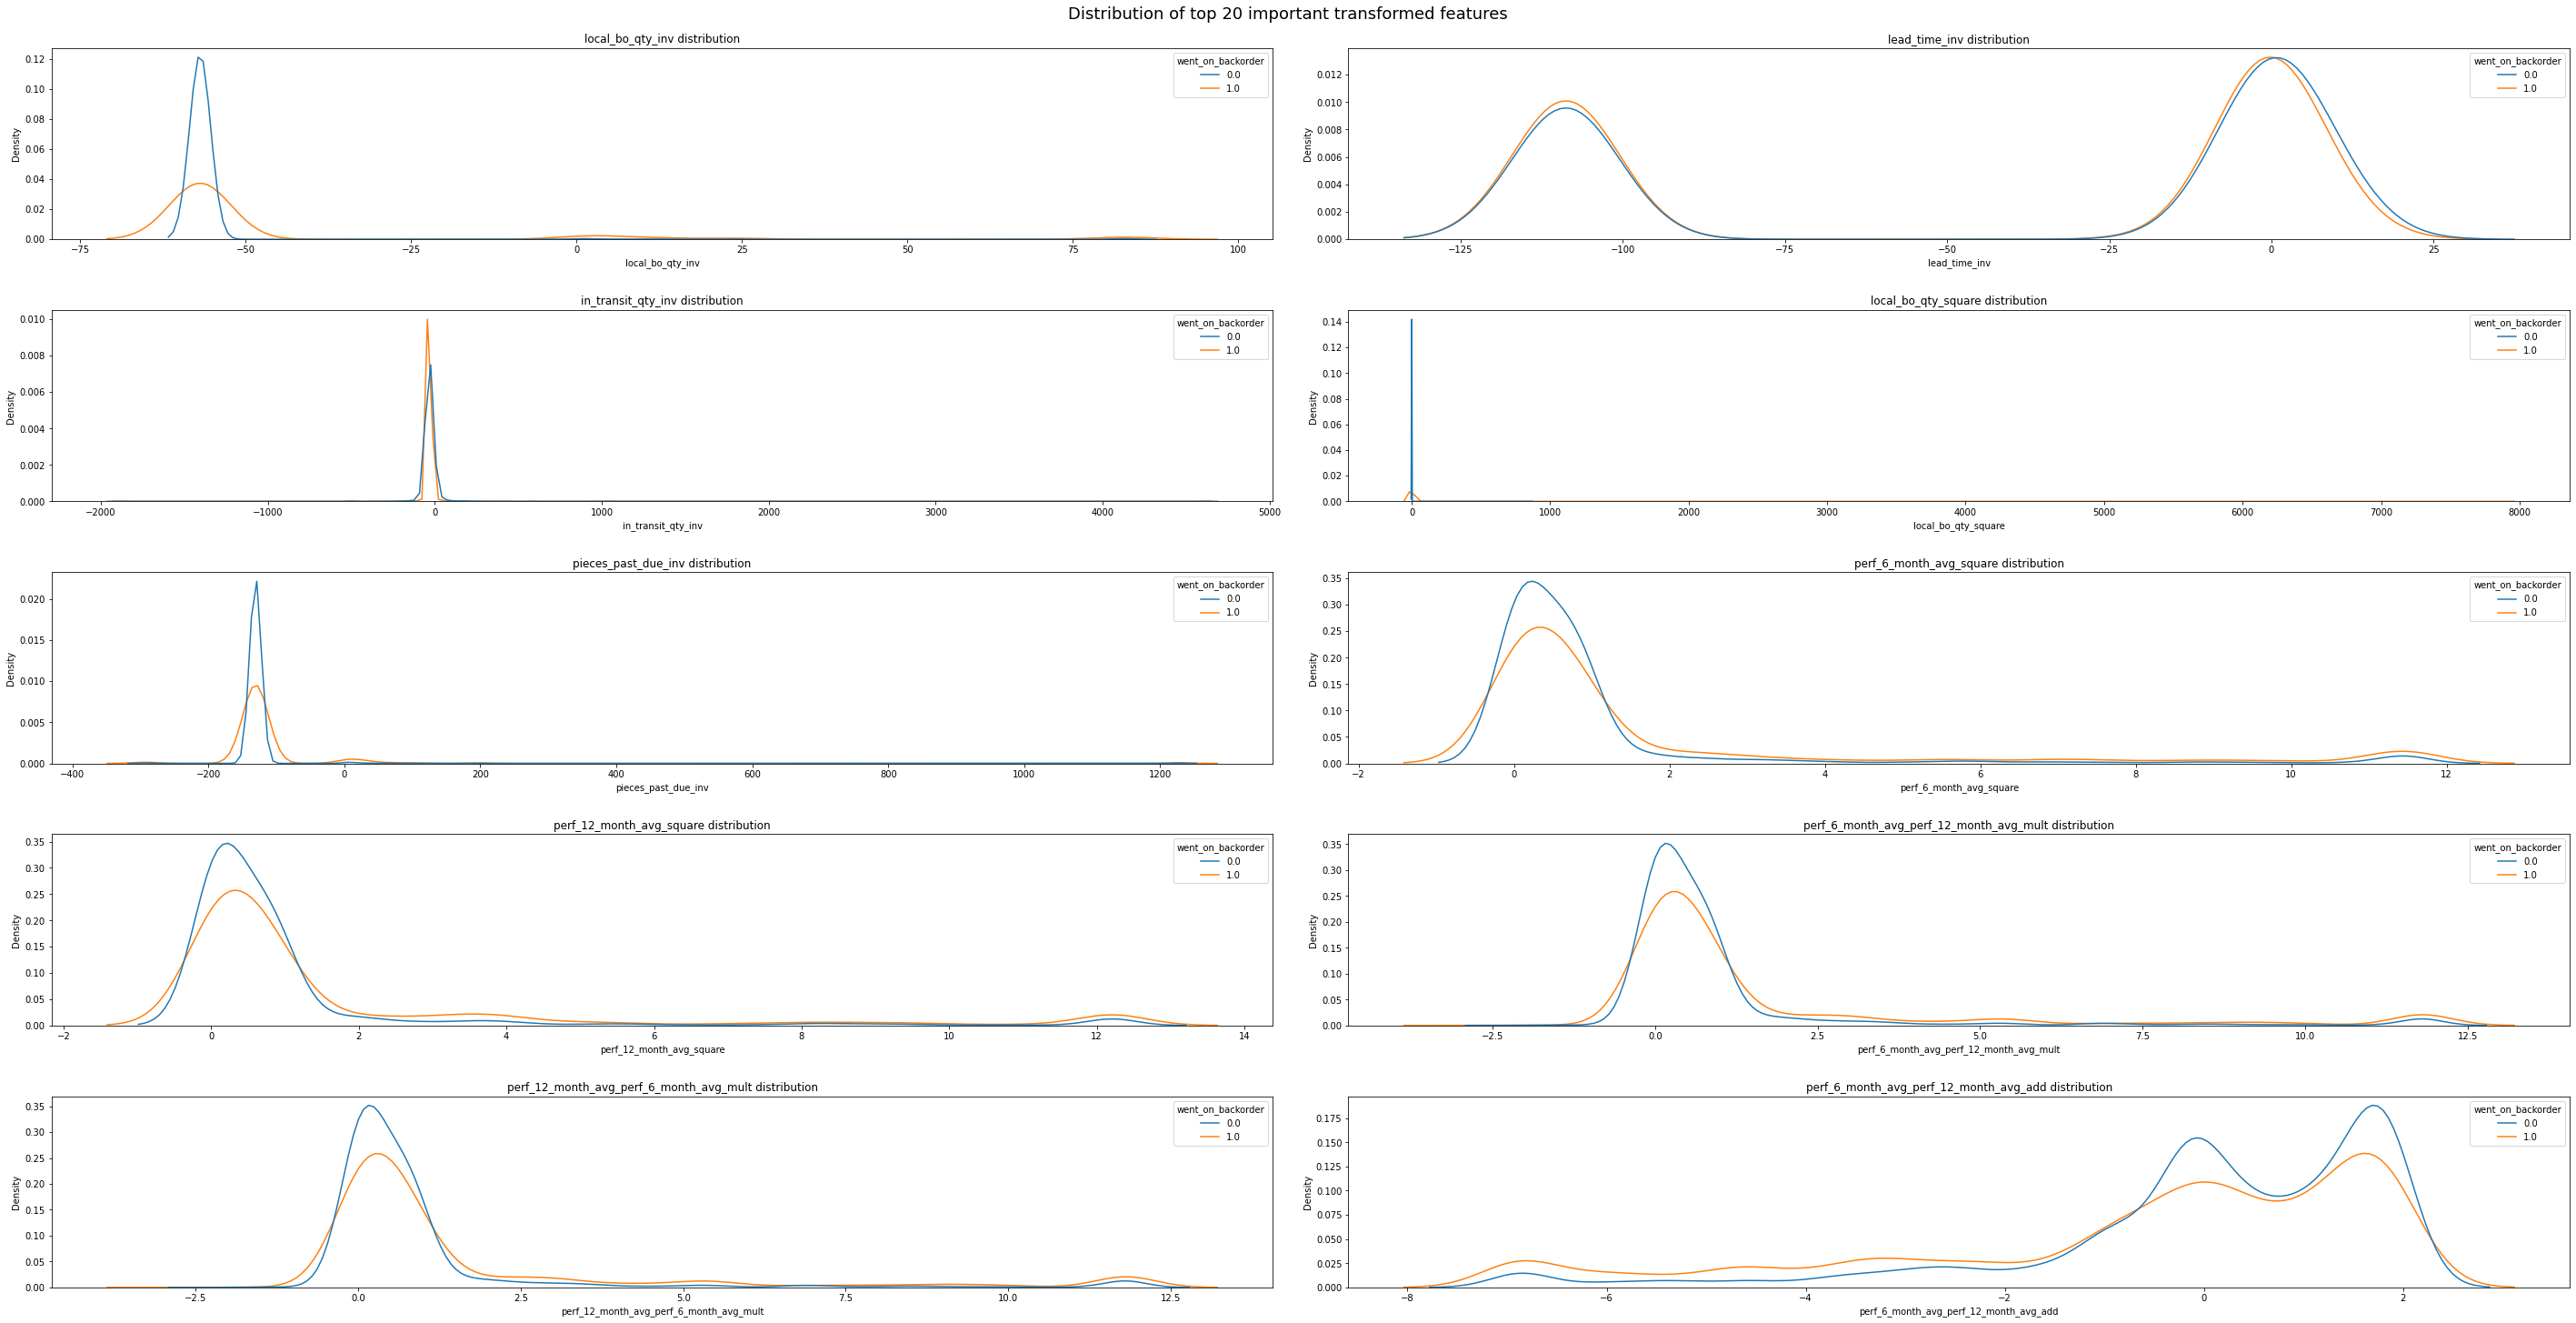

In [27]:
#Distribution of  newly created tranformed features

fig = plt.figure(figsize=(40,40))
for i,j in enumerate(sorted_idx[:10]):
  ax1=fig.add_subplot(10, 2, i+1)
  ax1.title.set_text(X_train_iter_trans_plt.columns[j]+' distribution')
  sns.kdeplot(data = X_train_iter_trans_plt, x=X_train_iter_trans_plt.columns[j], hue='went_on_backorder')
fig.tight_layout(pad=3.0)
fig.suptitle("Distribution of top 20 important transformed features", fontsize=18, y=1, x=.5)
plt.show()



* These newly created features are less skewed and  we are able to see some seperation between positve and negative points which will be helpful in classification

## 2.9 Selecting best features based on Recursive Feature Selection

In [28]:
#Assigning remaning columns to train and test data

for cols in ['potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop']:
  X_train_iter_trans[cols]=X_train_iter_under[cols]
  X_test_iter_trans[cols]=X_test_iter_stand[cols]


In [29]:
#Function to select best features iteratively based on roc_auc score
#Code referred from https://gist.github.com/rishabhrao1997/586d9d3d1c08adad80b2cf3abae2ba72#file-recursive_feature_selector-py

def best_feat(X_train,X_test,y_train,y_test,num_folds=4):
  
  '''
  Function to select most important features based on roc score
    
  Inputs:
      X_train: pandas DataFrame
               Training dataset
      X_test:  pandas DataFrame
               Test dataset
      y_train:  pandas DataFrame
               Target variables of train dataset
      y_test:  pandas DataFrame
               Target variables of test dataset   
       num_folds: int, default = 4
               Number of cross-validation folds for training and tuning the model
            
  Returns: 
      Train and Test data with reduced features
  '''
  
  roc_score = 1
  imp_cols=set()
  train_data=X_train
  target_train_data=y_train
  test_data=X_test
  target_test_data=y_test
  cols_list=list(train_data.columns)
  imp_cols_list=list(imp_cols)
  iter=1

  while (roc_score > 0.8) & (len(imp_cols_list)!=len(cols_list)):

    #Performing K-folds split
    train_data_rem = train_data[train_data.columns[~train_data.columns.isin(imp_cols_list)]]
    Kfold = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 33)
    splits= Kfold.split(train_data_rem, target_train_data)
    model_feature_importance = np.zeros_like(train_data_rem.columns)
    roc_scores=[]

    print("\nIteration -",iter)
    print('*********************')

    #Performing K-Fold Cross validation
    for fold_num,(train_idx, val_idx) in enumerate(splits,1):
      print("Fold-",fold_num)

                 
      #defining the train and validation data
      x_train = train_data_rem.iloc[train_idx]
      x_val = train_data_rem.iloc[val_idx]
      y_train = target_train_data.iloc[train_idx]
      y_val = target_train_data.iloc[val_idx]
                
      #Implementing the XGB Classifier
      xg = XGBClassifier(n_jobs = -1, random_state = 33)
      xg.fit(x_train, y_train)

      #Adding the feature importance of each feature averaged over different folds
      model_feature_importance += (xg.feature_importances_)

      #ROC-AUC Score for each K-fold
      roc=roc_auc_score(y_val, xg.predict_proba(x_val)[:,1])
      print("ROC score at the end of Fold-{} is {}".format(fold_num,roc))
      roc_scores.append(roc)
    
    #Mean of the scores over K-folds
    roc_score=mean(roc_scores)
    print('\n\nROC score at the end of iteration {} is {}'.format(iter,roc_score))

    #Average feature importances
    model_feature_importance=model_feature_importance/num_folds
    
    #getting the non-zero feature important indices
    imp_cols_idx = np.where(np.abs(model_feature_importance) > 0)

    #getting the non-zero feature important column names
    imp_cols_names = x_train.columns[imp_cols_idx]

    print("")

    #Appending important columns at each iteration       
    if roc_score > 0.8:
      imp_cols.update(imp_cols_names)
    
    imp_cols_list=list(imp_cols)
    
    print("Number of features at the end of iteration {} is {}\n\n".format(iter,len(imp_cols_list)) )
    iter+=1

  #Storing train and test data  
  train_data = train_data[imp_cols_list]
  test_data = test_data[imp_cols_list]

  return train_data, test_data


In [30]:
#Creating dataframe for target variable
y_train=pd.DataFrame(y_train_iter_trans,columns=['went_on_backorder'])
y_test=pd.DataFrame(y_test_iter_trans,columns=['went_on_backorder'])

x_train,x_test=best_feat(X_train_iter_trans,X_test_iter_trans,y_train,y_test,4)


Iteration - 1
*********************
Fold- 1
ROC score at the end of Fold-1 is 0.9512686787708011
Fold- 2
ROC score at the end of Fold-2 is 0.9526264050158602
Fold- 3
ROC score at the end of Fold-3 is 0.9458787559153349
Fold- 4
ROC score at the end of Fold-4 is 0.950659898719202


ROC score at the end of iteration 1 is 0.9501084346052995

Number of features at the end of iteration 1 is 227



Iteration - 2
*********************
Fold- 1
ROC score at the end of Fold-1 is 0.950632401389236
Fold- 2
ROC score at the end of Fold-2 is 0.9522246314420497
Fold- 3
ROC score at the end of Fold-3 is 0.9454391956964006
Fold- 4
ROC score at the end of Fold-4 is 0.950150069096156


ROC score at the end of iteration 2 is 0.9496115744059606

Number of features at the end of iteration 2 is 434



Iteration - 3
*********************
Fold- 1
ROC score at the end of Fold-1 is 0.9457798220605929
Fold- 2
ROC score at the end of Fold-2 is 0.9487900506663696
Fold- 3
ROC score at the end of Fold-3 is 0.94117641

# 3. Training Model

## 3.1 Train-Test Split

In [31]:
#Stratify split of train data
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train,random_state = 42 ,stratify=y_train,test_size=0.10)

## 3.2 Logistic Regression

In [32]:
#Define the grid search parameters
lr = LogisticRegression(n_jobs = -1)
parameters = {'penalty' : ['l1', 'l2'] , 'C' :  np.logspace(-1,4)}
clf = GridSearchCV(lr, parameters,n_jobs=-1,scoring = 'f1')
gs = clf.fit(x_train, y_train)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'C': 8.685113737513529, 'penalty': 'l2'}
Best Score :  0.5145954801199473


In [33]:
#Training on best parameters
lr = LogisticRegression(penalty = gs.best_params_['penalty'],C = gs.best_params_['C'],n_jobs=-1)
lr.fit(x_train, y_train)

#Storing predictions for train,cv and test data

y_pred_tr=lr.predict(x_train)
y_prob_tr=lr.predict_proba(x_train)[:,1]

y_pred_cv = lr.predict(x_cv)
y_prob_cv = lr.predict_proba(x_cv)[:,1]

y_pred_test = lr.predict(x_test)
y_prob_test = lr.predict_proba(x_test)[:,1]

#Displaying results
x = PrettyTable()
x.field_names = ['Data Set',  "Model", "AUROC", "F2 Score", "Recall", "Precision"]
dataset_type = ['Train', 'CV', 'Test']

for k in dataset_type:
  if k=='Train':
    roc = round(roc_auc_score(y_train, y_prob_tr),4)
    f2=round(fbeta_score(y_train,y_pred_tr, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_train, y_pred_tr),4)
    ps=round(average_precision_score(y_train, y_prob_tr),4)
    x.add_row([k, 'Logistic Regression', roc, f2, rs, ps])
  elif k == 'CV':
    roc = round(roc_auc_score(y_cv,y_prob_cv),4)
    f2=round(fbeta_score(y_cv,y_pred_cv, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_cv, y_pred_cv),4)
    ps=round(average_precision_score(y_cv, y_prob_cv),4)
    x.add_row([k, 'Logistic Regression', roc, f2, rs, ps])
  elif k == 'Test':
    roc = round(roc_auc_score(y_test,y_prob_test),4)
    f2=round(fbeta_score(y_test,y_pred_test, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_test, y_pred_test),4)
    ps=round(average_precision_score(y_test, y_prob_test),4)
    x.add_row([k, 'Logistic Regression', roc, f2, rs, ps])

print('\n')
print(x)



+----------+---------------------+--------+----------+--------+-----------+
| Data Set |        Model        | AUROC  | F2 Score | Recall | Precision |
+----------+---------------------+--------+----------+--------+-----------+
|  Train   | Logistic Regression | 0.5975 |  0.5366  | 0.483  |   0.5995  |
|    CV    | Logistic Regression | 0.5985 |  0.5325  | 0.4889 |   0.5961  |
|   Test   | Logistic Regression | 0.5761 |  0.7409  | 0.455  |   0.016   |
+----------+---------------------+--------+----------+--------+-----------+


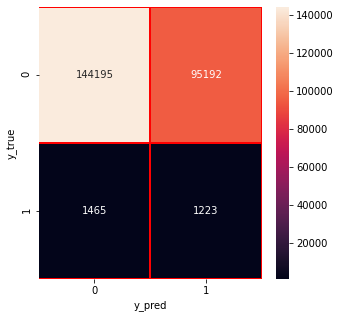

In [34]:
#Plot confusion matrix for test data

y_pred=y_pred_test
y_true=y_test

cm=confusion_matrix(y_true,y_pred)
f, ax=pyplot.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.5761')

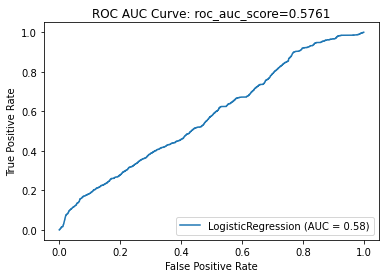

In [35]:
#Plot ROC-AUC curve for test data

roc = roc_auc_score(y_test,y_prob_test)
plt_roc = plot_roc_curve(lr, x_test, y_test)
plt_roc.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.0160')

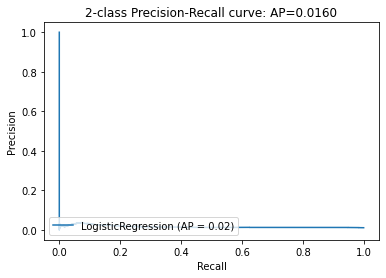

In [36]:
#Plot Precision-Recall Curve for test data

average_precision=average_precision_score(y_test, y_prob_test)
plt_pr_re = plot_precision_recall_curve(lr, x_test, y_test)
plt_pr_re.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

## 3.3 SVM with linear Kernel

In [37]:
#Define the grid search parameters

svm=SGDClassifier(loss='hinge',class_weight = 'balanced',n_jobs = -1)
parameters = {'penalty' : ['l1', 'l2'] , 'alpha' : np.logspace(-1,4) }
clf = GridSearchCV(svm, parameters,scoring = 'f1')
gs = clf.fit(x_train, y_train)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)


Best Params :  {'alpha': 1.6768329368110082, 'penalty': 'l1'}
Best Score :  0.6188383181080939


In [38]:
#Training on best parameters
svm = SGDClassifier(loss='hinge',class_weight = 'balanced',penalty = gs.best_params_['penalty'],alpha = gs.best_params_['alpha'],n_jobs=-1)
svm.fit(x_train, y_train)

#Storing predictions for train,cv and test data
y_pred_tr=svm.predict(x_train)
y_prob_tr=svm.decision_function(x_train)

y_pred_cv = svm.predict(x_cv)
y_prob_cv = svm.decision_function(x_cv)

y_pred_test = svm.predict(x_test)
y_prob_test = svm.decision_function(x_test)

#Displaying results
x = PrettyTable()
x.field_names = ['Data Set',  "Model", "AUROC", "F2 Score", "Recall", "Precision"]
dataset_type = ['Train', 'CV', 'Test']

for k in dataset_type:
  if k=='Train':
    roc = round(roc_auc_score(y_train, y_prob_tr),4)
    f2=round(fbeta_score(y_train,y_pred_tr, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_train, y_pred_tr),4)
    ps=round(average_precision_score(y_train, y_prob_tr),4)
    x.add_row([k, 'SVM', roc, f2, rs, ps])
  elif k == 'CV':
    roc = round(roc_auc_score(y_cv,y_prob_cv),4)
    f2=round(fbeta_score(y_cv,y_pred_cv, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_cv, y_pred_cv),4)
    ps=round(average_precision_score(y_cv, y_prob_cv),4)
    x.add_row([k, 'SVM', roc, f2, rs, ps])
  elif k == 'Test':
    roc = round(roc_auc_score(y_test,y_prob_test),4)
    f2=round(fbeta_score(y_test,y_pred_test, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_test, y_pred_test),4)
    ps=round(average_precision_score(y_test, y_prob_test),4)
    x.add_row([k, 'SVM', roc, f2, rs, ps])

print('\n')
print(x)



+----------+-------+--------+----------+--------+-----------+
| Data Set | Model | AUROC  | F2 Score | Recall | Precision |
+----------+-------+--------+----------+--------+-----------+
|  Train   |  SVM  | 0.5245 |  0.4893  | 0.5005 |   0.5277  |
|    CV    |  SVM  | 0.541  |  0.5011  | 0.5306 |   0.5365  |
|   Test   |  SVM  | 0.5077 |  0.6513  | 0.4829 |   0.0114  |
+----------+-------+--------+----------+--------+-----------+


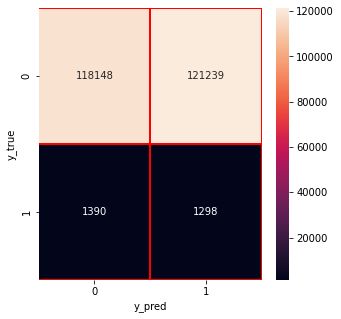

In [39]:
#Plot confusion matrix for test data

y_pred=y_pred_test
y_true=y_test

cm=confusion_matrix(y_true,y_pred)
f, ax=pyplot.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

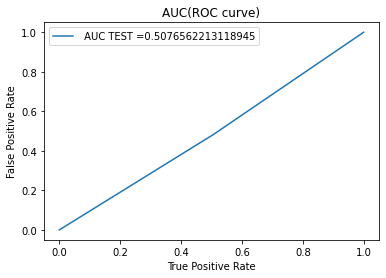

In [40]:
#Plot ROC-AUC curve

test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_test)
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(roc_auc_score(y_test,y_prob_test)))
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC(ROC curve)")
plt.show()

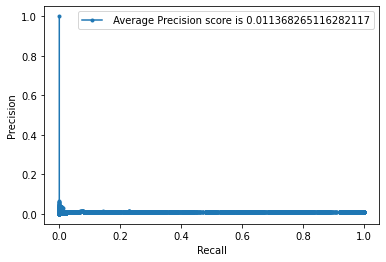

In [41]:
#Plot Precision-Recall Curve

average_precision=average_precision_score(y_test, y_prob_test)
precision, recall, _ = precision_recall_curve(y_test, y_prob_test)
plt.plot(recall, precision, marker='.', label=" Average Precision score is "+str(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## 3.4 Decision Tree

In [42]:
#Define the grid search parameters
dt = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15]}
clf = GridSearchCV(dt, parameters, scoring = 'f1')
gs = clf.fit(x_train, y_train)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'criterion': 'gini', 'max_depth': 12}
Best Score :  0.8833409611188507


In [43]:
#Training on best parameters
dt = DecisionTreeClassifier(criterion = gs.best_params_['criterion'], max_depth = gs.best_params_['max_depth'])
dt.fit(x_train, y_train)

#Storing predictions for train,cv and test data
y_pred_tr=dt.predict(x_train)
y_prob_tr=dt.predict_proba(x_train)[:,1]

y_pred_cv = dt.predict(x_cv)
y_prob_cv = dt.predict_proba(x_cv)[:,1]

y_pred_test = dt.predict(x_test)
y_prob_test = dt.predict_proba(x_test)[:,1]

#Displaying results
x = PrettyTable()
x.field_names = ['Data Set',  "Model", "AUROC", "F2 Score", "Recall", "Precision"]
dataset_type = ['Train', 'CV', 'Test']

for k in dataset_type:
  if k=='Train':
    roc = round(roc_auc_score(y_train, y_prob_tr),4)
    f2=round(fbeta_score(y_train,y_pred_tr, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_train, y_pred_tr),4)
    ps=round(average_precision_score(y_train, y_prob_tr),4)
    x.add_row([k, 'Decision Tree', roc, f2, rs, ps])
  elif k == 'CV':
    roc = round(roc_auc_score(y_cv,y_prob_cv),4)
    f2=round(fbeta_score(y_cv,y_pred_cv, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_cv, y_pred_cv),4)
    ps=round(average_precision_score(y_cv, y_prob_cv),4)
    x.add_row([k, 'Decision Tree', roc, f2, rs, ps])
  elif k == 'Test':
    roc = round(roc_auc_score(y_test,y_prob_test),4)
    f2=round(fbeta_score(y_test,y_pred_test, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_test, y_pred_test),4)
    ps=round(average_precision_score(y_test, y_prob_test),4)
    x.add_row([k, 'Decision Tree', roc, f2, rs, ps])

print('\n')
print(x)



+----------+---------------+--------+----------+--------+-----------+
| Data Set |     Model     | AUROC  | F2 Score | Recall | Precision |
+----------+---------------+--------+----------+--------+-----------+
|  Train   | Decision Tree | 0.9876 |  0.956   | 0.9649 |   0.9856  |
|    CV    | Decision Tree | 0.9028 |  0.8858  | 0.8964 |   0.861   |
|   Test   | Decision Tree | 0.8216 |  0.9211  | 0.776  |   0.0519  |
+----------+---------------+--------+----------+--------+-----------+


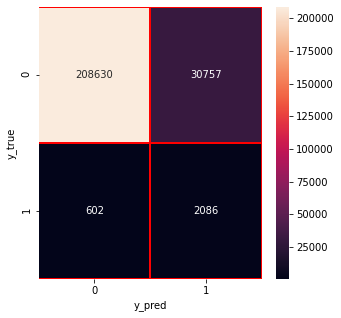

In [44]:
#Plot confusion matrix for test data

y_pred=y_pred_test
y_true=y_test

cm=confusion_matrix(y_true,y_pred)
f, ax=pyplot.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.8216')

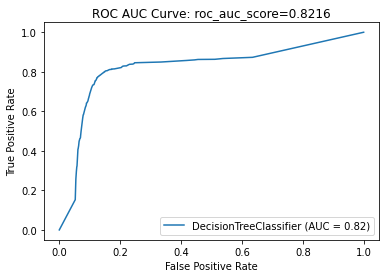

In [45]:
#Plot ROC-AUC curve

roc = roc_auc_score(y_test,y_prob_test)
plt_roc = plot_roc_curve(dt, x_test, y_test)
plt_roc.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.0519')

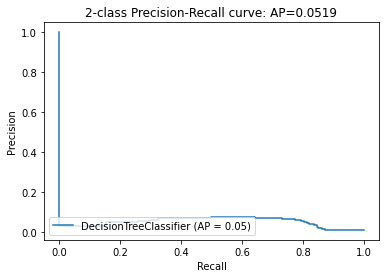

In [46]:
#Plot Precision-Recall Curve

average_precision=average_precision_score(y_test, y_prob_test)
plt_pr_re = plot_precision_recall_curve(dt, x_test, y_test)
plt_pr_re.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

## 3.5 Random Forest

In [47]:
#Define the grid search parameters
rf = RandomForestClassifier(n_jobs = -1)
parameters = {'n_estimators': [50,100,150,200], 'max_depth':[10,20,30,40,50,70,90,120]}
clf = GridSearchCV(rf, parameters, scoring = 'f1')
gs = clf.fit(x_train, y_train)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'max_depth': 120, 'n_estimators': 200}
Best Score :  0.9191619473037601


In [48]:
#Training on best parameters
rf = RandomForestClassifier(n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'])
rf.fit(x_train, y_train)

#Storing predictions for train,cv and test data
y_pred_tr=rf.predict(x_train)
y_prob_tr=rf.predict_proba(x_train)[:,1]

y_pred_cv = rf.predict(x_cv)
y_prob_cv = rf.predict_proba(x_cv)[:,1]

y_pred_test = rf.predict(x_test)
y_prob_test = rf.predict_proba(x_test)[:,1]

#Displaying results
x = PrettyTable()
x.field_names = ['Data Set',  "Model", "AUROC", "F2 Score", "Recall", "Precision"]
dataset_type = ['Train', 'CV', 'Test']

for k in dataset_type:
  if k=='Train':
    roc = round(roc_auc_score(y_train, y_prob_tr),4)
    f2=round(fbeta_score(y_train,y_pred_tr, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_train, y_pred_tr),4)
    ps=round(average_precision_score(y_train, y_prob_tr),4)
    x.add_row([k, 'Random Forest', roc, f2, rs, ps])
  elif k == 'CV':
    roc = round(roc_auc_score(y_cv,y_prob_cv),4)
    f2=round(fbeta_score(y_cv,y_pred_cv, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_cv, y_pred_cv),4)
    ps=round(average_precision_score(y_cv, y_prob_cv),4)
    x.add_row([k, 'Random Forest', roc, f2, rs, ps])
  elif k == 'Test':
    roc = round(roc_auc_score(y_test,y_prob_test),4)
    f2=round(fbeta_score(y_test,y_pred_test, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_test, y_pred_test),4)
    ps=round(average_precision_score(y_test, y_prob_test),4)
    x.add_row([k, 'Random Forest', roc, f2, rs, ps])

print('\n')
print(x)



+----------+---------------+--------+----------+--------+-----------+
| Data Set |     Model     | AUROC  | F2 Score | Recall | Precision |
+----------+---------------+--------+----------+--------+-----------+
|  Train   | Random Forest | 0.9999 |  0.998   | 0.998  |   0.9999  |
|    CV    | Random Forest | 0.9682 |  0.918   | 0.9469 |   0.9592  |
|   Test   | Random Forest | 0.928  |  0.9375  | 0.7976 |   0.1856  |
+----------+---------------+--------+----------+--------+-----------+


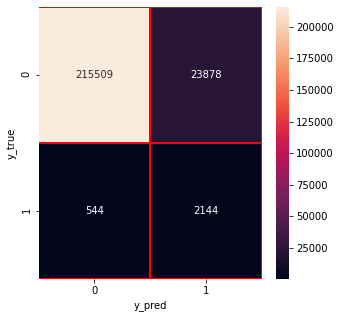

In [49]:
#Plot confusion matrix for test data

y_pred=y_pred_test
y_true=y_test

cm=confusion_matrix(y_true,y_pred)
f, ax=pyplot.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9280')

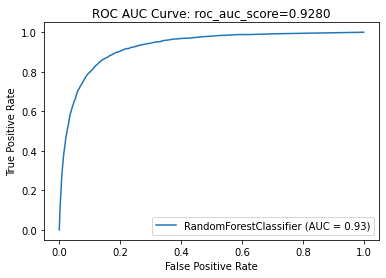

In [50]:
#Plot ROC-AUC curve

roc = roc_auc_score(y_test,y_prob_test)
plt_roc = plot_roc_curve(rf, x_test, y_test)
plt_roc.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.1856')

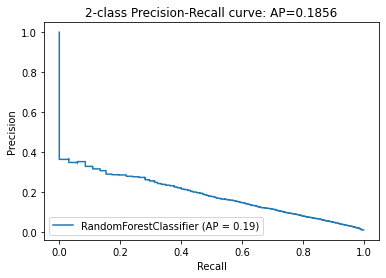

In [51]:
#Plot Precision-Recall Curve

average_precision=average_precision_score(y_test, y_prob_test)
plt_pr_re = plot_precision_recall_curve(rf, x_test, y_test)
plt_pr_re.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

## 3.6 XgBoost

In [52]:
#Define the grid search parameters
xgb = XGBClassifier()
parameters = {'n_estimators': [10, 100, 200, 500], 'max_depth':[5,7,10,20,30,50]}
clf = GridSearchCV(xgb, parameters, n_jobs=-1,scoring = 'f1')
gs = clf.fit(x_train, y_train)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'max_depth': 7, 'n_estimators': 500}
Best Score :  0.9235718878313582


In [53]:
#Training on best parameters
xgb = XGBClassifier(n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'], n_jobs=-1)
xgb.fit(x_train, y_train)

#Storing predictions for train,cv and test data
y_pred_tr=xgb.predict(x_train)
y_prob_tr=xgb.predict_proba(x_train)[:,1]

y_pred_cv = xgb.predict(x_cv)
y_prob_cv = xgb.predict_proba(x_cv)[:,1]

y_pred_test = xgb.predict(x_test)
y_prob_test = xgb.predict_proba(x_test)[:,1]

#Displaying results
x = PrettyTable()
x.field_names = ['Data Set',  "Model", "AUROC", "F2 Score", "Recall", "Precision"]
dataset_type = ['Train', 'CV', 'Test']

for k in dataset_type:
  if k=='Train':
    roc = round(roc_auc_score(y_train, y_prob_tr),4)
    f2=round(fbeta_score(y_train,y_pred_tr, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_train, y_pred_tr),4)
    ps=round(average_precision_score(y_train, y_prob_tr),4)
    x.add_row([k, 'XgBoost', roc, f2, rs, ps])
  elif k == 'CV':
    roc = round(roc_auc_score(y_cv,y_prob_cv),4)
    f2=round(fbeta_score(y_cv,y_pred_cv, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_cv, y_pred_cv),4)
    ps=round(average_precision_score(y_cv, y_prob_cv),4)
    x.add_row([k, 'XgBoost', roc, f2, rs, ps])
  elif k == 'Test':
    roc = round(roc_auc_score(y_test,y_prob_test),4)
    f2=round(fbeta_score(y_test,y_pred_test, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_test, y_pred_test),4)
    ps=round(average_precision_score(y_test, y_prob_test),4)
    x.add_row([k, 'XgBoost', roc, f2, rs, ps])

print('\n')
print(x)



+----------+---------+--------+----------+--------+-----------+
| Data Set |  Model  | AUROC  | F2 Score | Recall | Precision |
+----------+---------+--------+----------+--------+-----------+
|  Train   | XgBoost | 0.9999 |  0.9966  | 0.9979 |   0.9999  |
|    CV    | XgBoost | 0.9715 |  0.9229  | 0.9486 |   0.9659  |
|   Test   | XgBoost | 0.9302 |  0.9436  | 0.7794 |   0.2196  |
+----------+---------+--------+----------+--------+-----------+


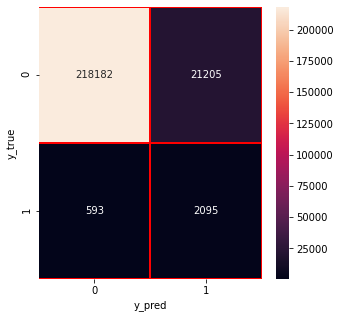

In [54]:
#Plot confusion matrix for test data

y_pred=y_pred_test
y_true=y_test

cm=confusion_matrix(y_true,y_pred)
f, ax=pyplot.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9302')

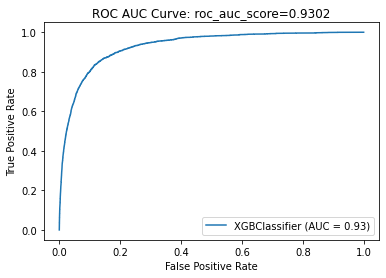

In [55]:
#Plot ROC-AUC curve

roc = roc_auc_score(y_test,y_prob_test)
plt_roc = plot_roc_curve(xgb, x_test, y_test)
plt_roc.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.2196')

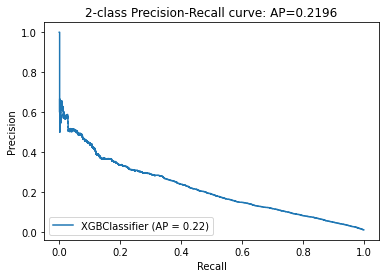

In [56]:
#Plot Precision-Recall Curve

average_precision=average_precision_score(y_test, y_prob_test)
plt_pr_re = plot_precision_recall_curve(xgb, x_test, y_test)
plt_pr_re.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

## 3.7 Light GBM

In [57]:
#Define the grid search parameters
lgbm = LGBMClassifier()
parameters = {'n_estimators': [10, 100, 200, 500], 'max_depth':[5,7,10,20,30,50]}
clf = GridSearchCV(lgbm, parameters, n_jobs=-1,scoring = 'f1')
gs = clf.fit(x_train, y_train)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)

Best Params :  {'max_depth': 30, 'n_estimators': 500}
Best Score :  0.9220507559605601


In [58]:
#Training on best parameters
lgbm = LGBMClassifier(n_estimators = gs.best_params_['n_estimators'], max_depth = gs.best_params_['max_depth'], n_jobs=-1)
lgbm.fit(x_train, y_train)

#Storing predictions for train,cv and test data
y_pred_tr=lgbm.predict(x_train)
y_prob_tr=lgbm.predict_proba(x_train)[:,1]

y_pred_cv = lgbm.predict(x_cv)
y_prob_cv = lgbm.predict_proba(x_cv)[:,1]

y_pred_test = lgbm.predict(x_test)
y_prob_test = lgbm.predict_proba(x_test)[:,1]

#Displaying results
x = PrettyTable()
x.field_names = ['Data Set',  "Model", "AUROC", "F2 Score", "Recall", "Precision"]
dataset_type = ['Train', 'CV', 'Test']

for k in dataset_type:
  if k=='Train':
    roc = round(roc_auc_score(y_train, y_prob_tr),4)
    f2=round(fbeta_score(y_train,y_pred_tr, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_train, y_pred_tr),4)
    ps=round(average_precision_score(y_train, y_prob_tr),4)
    x.add_row([k, 'Light GBM', roc, f2, rs, ps])
  elif k == 'CV':
    roc = round(roc_auc_score(y_cv,y_prob_cv),4)
    f2=round(fbeta_score(y_cv,y_pred_cv, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_cv, y_pred_cv),4)
    ps=round(average_precision_score(y_cv, y_prob_cv),4)
    x.add_row([k, 'Light GBM', roc, f2, rs, ps])
  elif k == 'Test':
    roc = round(roc_auc_score(y_test,y_prob_test),4)
    f2=round(fbeta_score(y_test,y_pred_test, pos_label = 1,average='weighted', beta=1),4)
    rs=round(recall_score(y_test, y_pred_test),4)
    ps=round(average_precision_score(y_test, y_prob_test),4)
    x.add_row([k, 'Light GBM', roc, f2, rs, ps])

print('\n')
print(x)



+----------+-----------+--------+----------+--------+-----------+
| Data Set |   Model   | AUROC  | F2 Score | Recall | Precision |
+----------+-----------+--------+----------+--------+-----------+
|  Train   | Light GBM | 0.9998 |  0.9949  | 0.9966 |   0.9998  |
|    CV    | Light GBM | 0.9709 |  0.9234  | 0.9433 |   0.9644  |
|   Test   | Light GBM | 0.9319 |  0.9426  | 0.7876 |   0.2202  |
+----------+-----------+--------+----------+--------+-----------+


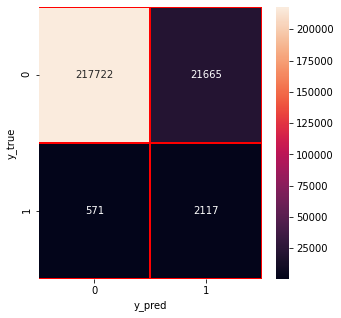

In [59]:
#Plot confusion matrix for test data

y_pred=y_pred_test
y_true=y_test

cm=confusion_matrix(y_true,y_pred)
f, ax=pyplot.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Text(0.5, 1.0, 'ROC AUC Curve: roc_auc_score=0.9319')

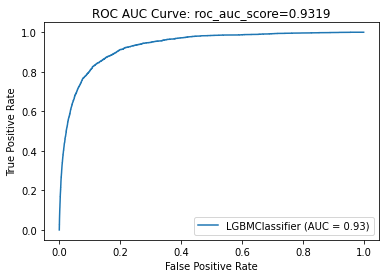

In [60]:
#Plot ROC-AUC curve

roc = roc_auc_score(y_test,y_prob_test)
plt_roc = plot_roc_curve(lgbm, x_test, y_test)
plt_roc.ax_.set_title('ROC AUC Curve: roc_auc_score={0:0.4f}'.format(roc))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.2202')

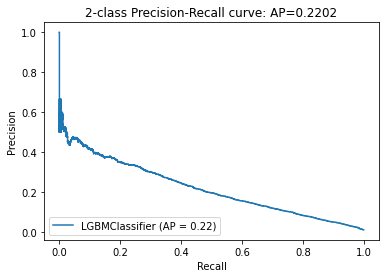

In [61]:
#Plot Precision-Recall Curve

average_precision=average_precision_score(y_test, y_prob_test)
plt_pr_re = plot_precision_recall_curve(lgbm, x_test, y_test)
plt_pr_re.ax_.set_title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision))

**Observations**
* It is found that Light GBM gave the best result with auc score of 0.93

## 3.8 Saving the best performed model and features

In [63]:
#Saving model using joblib
model_pick_file = 'backorder_best_model.pkl'
joblib.dump(lgbm, open(model_pick_file, 'wb'))

#Saving best feature columns for prediction
feat_file='test_best_feat.pkl'
joblib.dump(x_test.columns, open(feat_file, 'wb'))

#Saving the test data
x_test.to_csv('Test_dataset.csv.gz',compression='gzip')

#Saving the standardization object instance
joblib.dump(sc,open('sc.pkl', 'wb'))